In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import re
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

mean: 51.47414634146342, var: 937.6247582997061


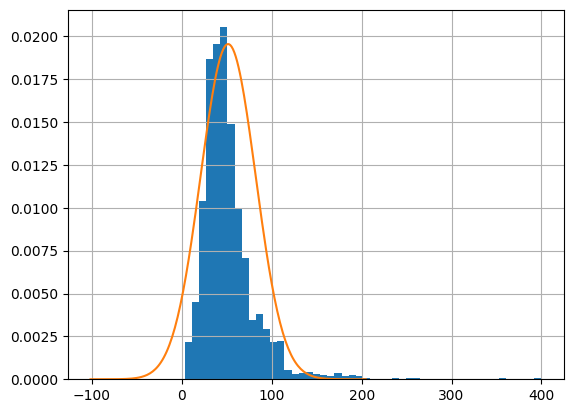

In [2]:
data = pd.read_csv('./Q1 Materials/BBBP.csv')
molcules_length = data['smiles'].apply(len)

plt.figure()
molcules_length.hist(bins=50, density=True)
mean = molcules_length.mean()
var = molcules_length.var()
std = np.sqrt(var)
x = np.linspace(mean-5*std,mean+5*std,200)
plt.plot(x,1.5*stats.norm.pdf(x,mean, std))
print(f'mean: {mean}, var: {var}')
plt.show()

As you can See it looks like guassian distribution, $\mathcal{N}(51,938)$, with mean 51 and variance 938.

In [3]:
SMI_REGEX_PATTERN = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|\+|\\\/|:|@|\?|>|\*|\$|%[0-9]{2}|[0-9])"
find_tokens = lambda smiles: re.findall(SMI_REGEX_PATTERN,smiles)

tokens = data['smiles'].apply(find_tokens)
data['tokens'] = tokens
counter = Counter(tokens.explode())
print('There is ',len(counter),' tokens')
print(counter)

There is  69  tokens
Counter({'C': 26859, '(': 10491, ')': 10491, '=': 8034, 'c': 6937, 'O': 6142, '1': 4100, 'N': 3724, '2': 3362, '3': 2548, '4': 1434, '[C@H]': 1354, '[C@@H]': 893, 'Cl': 570, 'F': 509, 'n': 472, '5': 454, 'S': 405, '[C@@]': 350, '[C@]': 323, '.': 163, '6': 124, '[S]': 103, '[N]': 77, 's': 72, '[O-]': 64, '7': 56, '#': 53, '[NH]': 50, '[N+]': 49, 'o': 48, 'Br': 45, '[Cl-]': 43, '[nH]': 40, '[H+]': 40, '8': 28, '[Na+]': 19, '9': 16, '[N@]': 14, '[P]': 11, '[N@@]': 8, '%10': 8, 'I': 6, '[Br-]': 6, '[Cl]': 5, '[H]': 4, '[N-]': 4, '%11': 4, '%12': 4, '%13': 4, '%14': 4, '[n+]': 2, '[NH+]': 2, '[Na]': 2, '[C-]': 2, '[NH2+]': 2, '[NH2]': 1, '[Ca++]': 1, '[S@]': 1, '[OH-]': 1, '[nH+]': 1, '[o+]': 1, '[NH3+]': 1, '[CH2-]': 1, '[CH-]': 1, 'B': 1, '[S+]': 1, '[O+]': 1, '[NH-]': 1})


We see about 1024 tokens we have, and the frequency of the most common of them are printed above.

In [4]:
str2int = {}
int2str = {}
idxs = np.arange(1,len(counter)+1)
np.random.shuffle(idxs)
max_length = data['tokens'].apply(len).max()
for key, idx in zip(counter.keys(), idxs):
    if key not in str2int:
        str2int[key] = idx
        int2str[idx] = key

one_hot_encoding = lambda tokens: np.concatenate([[str2int[token] for token in tokens],np.zeros(max_length-len(tokens),dtype=np.int32)])
data['one_hot_encoded'] = data['tokens'].apply(one_hot_encoding)

In [5]:
class ChemDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __getitem__(self, index):
        seq = torch.tensor(self.data['one_hot_encoded'][index])
        label = self.data['p_np'][index]
        return seq, label
    
    def __len__(self):
        return len(self.data)

In [6]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = ChemDataset(data)
trainset, testset = random_split(dataset, [0.8,0.2])

trainLoader = DataLoader(trainset, batch_size, shuffle=True)
testLoader = DataLoader(testset, batch_size, shuffle=True)

In [22]:
class BaseModel(nn.Module):
    def __init__(self, max_length):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(max_length,256),nn.ReLU(),nn.Linear(256,32),nn.ReLU(),nn.Linear(32,1))

    def forward(self, x):
        y = self.model(x.type(torch.float32))
        return y.squeeze()

In [8]:
def evaluation(model, testLoader):
    model.eval()
    acc = 0.0
    with torch.no_grad():
       
        for i, (seq, target) in tqdm(enumerate(testLoader),total=len(testLoader), desc=f'evaluation'):

            seq = seq.to(device)
            target = target.to(device)

            label = model(seq)
            pred = (label>0.5).type(torch.int32)
            acc += (pred == target).cpu().sum()

    acc /= len(testset)
    print(f'Accuracy on testset: {acc*100}%')

In [143]:
model = BaseModel(max_length).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)

train_losses = []
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for i, (seq, target) in tqdm(enumerate(trainLoader),total=len(trainLoader), desc=f'epoch {epoch}'):
        optimizer.zero_grad()

        seq = seq.to(device)
        target = target.type(torch.float32).to(device)

        label = model(seq)
        loss = criterion(label, target)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(target)
    
    total_loss /= len(trainset)
    train_losses.append(total_loss)
    print('loss: ',total_loss)
    evaluation(model, testLoader)

epoch 0: 100%|██████████| 52/52 [00:00<00:00, 163.95it/s]


loss:  0.5045570216527799


evaluation: 100%|██████████| 13/13 [00:00<00:00, 352.30it/s]


Accuracy on testset: 76.34146118164062%


epoch 1: 100%|██████████| 52/52 [00:00<00:00, 272.98it/s]


loss:  0.4268017425769713


evaluation: 100%|██████████| 13/13 [00:00<00:00, 651.55it/s]


Accuracy on testset: 79.26829528808594%


epoch 2: 100%|██████████| 52/52 [00:00<00:00, 301.32it/s]


loss:  0.3826966096715229


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.43it/s]


Accuracy on testset: 79.0243911743164%


epoch 3: 100%|██████████| 52/52 [00:00<00:00, 264.67it/s]


loss:  0.3424931911433615


evaluation: 100%|██████████| 13/13 [00:00<00:00, 465.59it/s]


Accuracy on testset: 81.21951293945312%


epoch 4: 100%|██████████| 52/52 [00:00<00:00, 266.01it/s]


loss:  0.31713028099478746


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.40it/s]


Accuracy on testset: 78.53659057617188%


epoch 5: 100%|██████████| 52/52 [00:00<00:00, 264.66it/s]


loss:  0.2997375531167519


evaluation: 100%|██████████| 13/13 [00:00<00:00, 521.37it/s]


Accuracy on testset: 69.0243911743164%


epoch 6: 100%|██████████| 52/52 [00:00<00:00, 277.34it/s]


loss:  0.2622247759161926


evaluation: 100%|██████████| 13/13 [00:00<00:00, 543.10it/s]


Accuracy on testset: 79.51219940185547%


epoch 7: 100%|██████████| 52/52 [00:00<00:00, 310.34it/s]


loss:  0.23943604203622515


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.71it/s]


Accuracy on testset: 81.70731353759766%


epoch 8: 100%|██████████| 52/52 [00:00<00:00, 302.21it/s]


loss:  0.20609243323163287


evaluation: 100%|██████████| 13/13 [00:00<00:00, 521.34it/s]


Accuracy on testset: 80.73170471191406%


epoch 9: 100%|██████████| 52/52 [00:00<00:00, 294.57it/s]


loss:  0.19974054185355583


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.68it/s]


Accuracy on testset: 77.07316589355469%


epoch 10: 100%|██████████| 52/52 [00:00<00:00, 300.15it/s]


loss:  0.1725425239743256


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.48it/s]


Accuracy on testset: 78.04877471923828%


epoch 11: 100%|██████████| 52/52 [00:00<00:00, 298.85it/s]


loss:  0.17396554719747567


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.48it/s]


Accuracy on testset: 81.95121765136719%


epoch 12: 100%|██████████| 52/52 [00:00<00:00, 299.82it/s]


loss:  0.13810201076472678


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.50it/s]


Accuracy on testset: 83.41463470458984%


epoch 13: 100%|██████████| 52/52 [00:00<00:00, 294.63it/s]


loss:  0.12801269023883632


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.53it/s]


Accuracy on testset: 79.75609588623047%


epoch 14: 100%|██████████| 52/52 [00:00<00:00, 280.56it/s]


loss:  0.14245524003011426


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.70it/s]


Accuracy on testset: 81.46341705322266%


epoch 15: 100%|██████████| 52/52 [00:00<00:00, 298.82it/s]


loss:  0.1159992891295654


evaluation: 100%|██████████| 13/13 [00:00<00:00, 543.14it/s]


Accuracy on testset: 82.68292236328125%


epoch 16: 100%|██████████| 52/52 [00:00<00:00, 294.57it/s]


loss:  0.08720710357514823


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.74it/s]


Accuracy on testset: 81.70731353759766%


epoch 17: 100%|██████████| 52/52 [00:00<00:00, 296.25it/s]


loss:  0.07023304886207347


evaluation: 100%|██████████| 13/13 [00:00<00:00, 543.10it/s]


Accuracy on testset: 81.70731353759766%


epoch 18: 100%|██████████| 52/52 [00:00<00:00, 293.43it/s]


loss:  0.06655546547617854


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.50it/s]


Accuracy on testset: 80.9756088256836%


epoch 19: 100%|██████████| 52/52 [00:00<00:00, 274.42it/s]


loss:  0.0796739129667602


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.72it/s]


Accuracy on testset: 79.26829528808594%


epoch 20: 100%|██████████| 52/52 [00:00<00:00, 297.94it/s]


loss:  0.06751003917533814


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.66it/s]


Accuracy on testset: 81.95121765136719%


epoch 21: 100%|██████████| 52/52 [00:00<00:00, 298.90it/s]


loss:  0.06070248246102072


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.49it/s]


Accuracy on testset: 81.95121765136719%


epoch 22: 100%|██████████| 52/52 [00:00<00:00, 293.73it/s]


loss:  0.038090440903495


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.53it/s]


Accuracy on testset: 80.24390411376953%


epoch 23: 100%|██████████| 52/52 [00:00<00:00, 294.05it/s]


loss:  0.03223631865594809


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.48it/s]


Accuracy on testset: 82.19512176513672%


epoch 24: 100%|██████████| 52/52 [00:00<00:00, 280.41it/s]


loss:  0.035008313390994215


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.48it/s]


Accuracy on testset: 82.43902587890625%


epoch 25: 100%|██████████| 52/52 [00:00<00:00, 295.79it/s]


loss:  0.05096472956512759


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.49it/s]


Accuracy on testset: 82.19512176513672%


epoch 26: 100%|██████████| 52/52 [00:00<00:00, 289.90it/s]


loss:  0.07956091629840979


evaluation: 100%|██████████| 13/13 [00:00<00:00, 651.76it/s]


Accuracy on testset: 82.68292236328125%


epoch 27: 100%|██████████| 52/52 [00:00<00:00, 292.25it/s]


loss:  0.12065215768610558


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.70it/s]


Accuracy on testset: 80.9756088256836%


epoch 28: 100%|██████████| 52/52 [00:00<00:00, 292.25it/s]


loss:  0.040350975968488835


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.71it/s]


Accuracy on testset: 81.70731353759766%


epoch 29: 100%|██████████| 52/52 [00:00<00:00, 259.40it/s]


loss:  0.03902150261238581


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.48it/s]


Accuracy on testset: 81.46341705322266%


epoch 30: 100%|██████████| 52/52 [00:00<00:00, 291.28it/s]


loss:  0.02623152646531419


evaluation: 100%|██████████| 13/13 [00:00<00:00, 543.10it/s]


Accuracy on testset: 81.46341705322266%


epoch 31: 100%|██████████| 52/52 [00:00<00:00, 294.57it/s]


loss:  0.017618037373318747


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.71it/s]


Accuracy on testset: 81.95121765136719%


epoch 32: 100%|██████████| 52/52 [00:00<00:00, 277.33it/s]


loss:  0.016166610990526017


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.71it/s]


Accuracy on testset: 82.68292236328125%


epoch 33: 100%|██████████| 52/52 [00:00<00:00, 289.66it/s]


loss:  0.010793657621749246


evaluation: 100%|██████████| 13/13 [00:00<00:00, 543.11it/s]


Accuracy on testset: 83.17073059082031%


epoch 34: 100%|██████████| 52/52 [00:00<00:00, 264.67it/s]


loss:  0.00873375361410492


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.50it/s]


Accuracy on testset: 82.19512176513672%


epoch 35: 100%|██████████| 52/52 [00:00<00:00, 274.42it/s]


loss:  0.00736993409071413


evaluation: 100%|██████████| 13/13 [00:00<00:00, 501.33it/s]


Accuracy on testset: 82.19512176513672%


epoch 36: 100%|██████████| 52/52 [00:00<00:00, 267.38it/s]


loss:  0.006744485990167028


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.45it/s]


Accuracy on testset: 83.17073059082031%


epoch 37: 100%|██████████| 52/52 [00:00<00:00, 251.88it/s]


loss:  0.006920288063631189


evaluation: 100%|██████████| 13/13 [00:00<00:00, 620.70it/s]


Accuracy on testset: 82.43902587890625%


epoch 38: 100%|██████████| 52/52 [00:00<00:00, 277.33it/s]


loss:  0.007273542446016175


evaluation: 100%|██████████| 13/13 [00:00<00:00, 465.51it/s]


Accuracy on testset: 80.9756088256836%


epoch 39: 100%|██████████| 52/52 [00:00<00:00, 217.70it/s]


loss:  0.010396647736112156


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.49it/s]


Accuracy on testset: 83.41463470458984%


epoch 40: 100%|██████████| 52/52 [00:00<00:00, 292.67it/s]


loss:  0.006468717593177244


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.49it/s]


Accuracy on testset: 82.92682647705078%


epoch 41: 100%|██████████| 52/52 [00:00<00:00, 233.80it/s]


loss:  0.010162347156154106


evaluation: 100%|██████████| 13/13 [00:00<00:00, 482.73it/s]


Accuracy on testset: 80.48780822753906%


epoch 42: 100%|██████████| 52/52 [00:00<00:00, 266.02it/s]


loss:  0.04251468995040873


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.70it/s]


Accuracy on testset: 77.31707000732422%


epoch 43: 100%|██████████| 52/52 [00:00<00:00, 242.50it/s]


loss:  0.10518961462941838


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.47it/s]


Accuracy on testset: 80.9756088256836%


epoch 44: 100%|██████████| 52/52 [00:00<00:00, 260.93it/s]


loss:  0.05594325579728409


evaluation: 100%|██████████| 13/13 [00:00<00:00, 651.73it/s]


Accuracy on testset: 77.56097412109375%


epoch 45: 100%|██████████| 52/52 [00:00<00:00, 273.28it/s]


loss:  0.06996684710881332


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]


Accuracy on testset: 82.68292236328125%


epoch 46: 100%|██████████| 52/52 [00:00<00:00, 245.94it/s]


loss:  0.06089148951421787


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.92it/s]


Accuracy on testset: 79.51219940185547%


epoch 47: 100%|██████████| 52/52 [00:00<00:00, 296.25it/s]


loss:  0.10897068553263457


evaluation: 100%|██████████| 13/13 [00:00<00:00, 592.52it/s]


Accuracy on testset: 76.82926940917969%


epoch 48: 100%|██████████| 52/52 [00:00<00:00, 238.07it/s]


loss:  0.06426916105570499


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.44it/s]


Accuracy on testset: 82.68292236328125%


epoch 49: 100%|██████████| 52/52 [00:00<00:00, 270.15it/s]


loss:  0.028992207739047888


evaluation: 100%|██████████| 13/13 [00:00<00:00, 566.72it/s]

Accuracy on testset: 82.68292236328125%


The Accuracy of this model is **82.68%**

In [21]:
class ChemLSTM(nn.Module):
    def __init__(self,hidden_size=32, length=231):
        super().__init__()
        self.embedding = nn.Embedding(70,hidden_size,0)
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*length,256), nn.ReLU(), nn.Linear(256,1))
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = torch.flatten(out,1) # N x 32*231
        out = self.fc(out)
        return out.squeeze()

In [15]:
model = ChemLSTM().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)

train_losses = []
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for i, (seq, target) in tqdm(enumerate(trainLoader),total=len(trainLoader), desc=f'epoch {epoch}'):
        optimizer.zero_grad()

        seq = seq.to(device)
        target = target.type(torch.float32).to(device)

        label = model(seq)
        loss = criterion(label, target)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(target)
    
    total_loss /= len(trainset)
    train_losses.append(total_loss)
    print('loss: ',total_loss)
    evaluation(model, testLoader)

epoch 0: 100%|██████████| 52/52 [00:00<00:00, 94.54it/s] 


loss:  0.39747601580329056


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.43it/s]


Accuracy on testset: 82.19512176513672%


epoch 1: 100%|██████████| 52/52 [00:00<00:00, 162.09it/s]


loss:  0.2789908281186732


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.43it/s]


Accuracy on testset: 86.82926940917969%


epoch 2: 100%|██████████| 52/52 [00:00<00:00, 150.76it/s]


loss:  0.2201367000981075


evaluation: 100%|██████████| 13/13 [00:00<00:00, 334.19it/s]


Accuracy on testset: 86.58536529541016%


epoch 3: 100%|██████████| 52/52 [00:00<00:00, 153.45it/s]


loss:  0.18590306270776724


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.37it/s]


Accuracy on testset: 88.29267883300781%


epoch 4: 100%|██████████| 52/52 [00:00<00:00, 162.11it/s]


loss:  0.15821278880282147


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.51it/s]


Accuracy on testset: 89.0243911743164%


epoch 5: 100%|██████████| 52/52 [00:00<00:00, 168.01it/s]


loss:  0.1399116809877408


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.35it/s]


Accuracy on testset: 87.31707000732422%


epoch 6: 100%|██████████| 52/52 [00:00<00:00, 167.51it/s]


loss:  0.1179492087171572


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 88.53658294677734%


epoch 7: 100%|██████████| 52/52 [00:00<00:00, 164.01it/s]


loss:  0.0899172133061944


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.48it/s]


Accuracy on testset: 89.51219177246094%


epoch 8: 100%|██████████| 52/52 [00:00<00:00, 160.73it/s]


loss:  0.07216210795975313


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.41it/s]


Accuracy on testset: 89.51219177246094%


epoch 9: 100%|██████████| 52/52 [00:00<00:00, 162.03it/s]


loss:  0.0772294612919412


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.97it/s]


Accuracy on testset: 89.51219177246094%


epoch 10: 100%|██████████| 52/52 [00:00<00:00, 158.74it/s]


loss:  0.05772703898582244


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.41it/s]


Accuracy on testset: 86.82926940917969%


epoch 11: 100%|██████████| 52/52 [00:00<00:00, 162.76it/s]


loss:  0.04470740497657438


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.49it/s]


Accuracy on testset: 89.2682876586914%


epoch 12: 100%|██████████| 52/52 [00:00<00:00, 158.41it/s]


loss:  0.03518687358080614


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.48it/s]


Accuracy on testset: 89.0243911743164%


epoch 13: 100%|██████████| 52/52 [00:00<00:00, 160.13it/s]


loss:  0.023368550105610997


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.47it/s]


Accuracy on testset: 89.51219177246094%


epoch 14: 100%|██████████| 52/52 [00:00<00:00, 158.60it/s]


loss:  0.020175001079716332


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.43it/s]


Accuracy on testset: 88.04878234863281%


epoch 15: 100%|██████████| 52/52 [00:00<00:00, 163.50it/s]


loss:  0.021273384772939608


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 90.243896484375%


epoch 16: 100%|██████████| 52/52 [00:00<00:00, 156.66it/s]


loss:  0.013440569950176812


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.46it/s]


Accuracy on testset: 90.0%


epoch 17: 100%|██████████| 52/52 [00:00<00:00, 167.78it/s]


loss:  0.011757542920389736


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.46it/s]


Accuracy on testset: 90.48780059814453%


epoch 18: 100%|██████████| 52/52 [00:00<00:00, 163.00it/s]


loss:  0.011285585822060523


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.49it/s]


Accuracy on testset: 88.78048706054688%


epoch 19: 100%|██████████| 52/52 [00:00<00:00, 169.71it/s]


loss:  0.01276587196852921


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.43it/s]


Accuracy on testset: 88.29267883300781%


epoch 20: 100%|██████████| 52/52 [00:00<00:00, 158.96it/s]


loss:  0.013263354352788954


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.46it/s]


Accuracy on testset: 88.78048706054688%


epoch 21: 100%|██████████| 52/52 [00:00<00:00, 164.49it/s]


loss:  0.008167339574613767


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 88.04878234863281%


epoch 22: 100%|██████████| 52/52 [00:00<00:00, 160.75it/s]


loss:  0.006290029946633628


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 90.0%


epoch 23: 100%|██████████| 52/52 [00:00<00:00, 162.19it/s]


loss:  0.007760731349826972


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.50it/s]


Accuracy on testset: 89.51219177246094%


epoch 24: 100%|██████████| 52/52 [00:00<00:00, 153.70it/s]


loss:  0.0048538177549589155


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.49it/s]


Accuracy on testset: 90.243896484375%


epoch 25: 100%|██████████| 52/52 [00:00<00:00, 163.27it/s]


loss:  0.005465386694058685


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.50it/s]


Accuracy on testset: 88.78048706054688%


epoch 26: 100%|██████████| 52/52 [00:00<00:00, 164.02it/s]


loss:  0.004291887594125711


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.50it/s]


Accuracy on testset: 89.0243911743164%


epoch 27: 100%|██████████| 52/52 [00:00<00:00, 165.15it/s]


loss:  0.010096325044429338


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 89.75609588623047%


epoch 28: 100%|██████████| 52/52 [00:00<00:00, 155.12it/s]


loss:  0.005893327283569106


evaluation: 100%|██████████| 13/13 [00:00<00:00, 449.48it/s]


Accuracy on testset: 87.80487823486328%


epoch 29: 100%|██████████| 52/52 [00:00<00:00, 163.97it/s]


loss:  0.003772011482747408


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.36it/s]


Accuracy on testset: 88.78048706054688%


epoch 30: 100%|██████████| 52/52 [00:00<00:00, 164.18it/s]


loss:  0.003942550372945644


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.46it/s]


Accuracy on testset: 90.7317123413086%


epoch 31: 100%|██████████| 52/52 [00:00<00:00, 160.28it/s]


loss:  0.005021990516376341


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.51it/s]


Accuracy on testset: 90.0%


epoch 32: 100%|██████████| 52/52 [00:00<00:00, 167.13it/s]


loss:  0.002712084319465226


evaluation: 100%|██████████| 13/13 [00:00<00:00, 352.27it/s]


Accuracy on testset: 89.75609588623047%


epoch 33: 100%|██████████| 52/52 [00:00<00:00, 168.03it/s]


loss:  0.0021363675805155143


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.49it/s]


Accuracy on testset: 89.51219177246094%


epoch 34: 100%|██████████| 52/52 [00:00<00:00, 165.45it/s]


loss:  0.003074432490960151


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]


Accuracy on testset: 89.75609588623047%


epoch 35: 100%|██████████| 52/52 [00:00<00:00, 158.00it/s]


loss:  0.001606769395052319


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 89.75609588623047%


epoch 36: 100%|██████████| 52/52 [00:00<00:00, 156.11it/s]


loss:  0.0012893710210890987


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.35it/s]


Accuracy on testset: 89.51219177246094%


epoch 37: 100%|██████████| 52/52 [00:00<00:00, 160.92it/s]


loss:  0.001463954991741935


evaluation: 100%|██████████| 13/13 [00:00<00:00, 343.02it/s]


Accuracy on testset: 89.75609588623047%


epoch 38: 100%|██████████| 52/52 [00:00<00:00, 162.93it/s]


loss:  0.0010731992876815905


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.32it/s]


Accuracy on testset: 89.75609588623047%


epoch 39: 100%|██████████| 52/52 [00:00<00:00, 150.69it/s]


loss:  0.001503468824801796


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.34it/s]


Accuracy on testset: 89.2682876586914%


epoch 40: 100%|██████████| 52/52 [00:00<00:00, 164.52it/s]


loss:  0.0007891175872007407


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.36it/s]


Accuracy on testset: 90.0%


epoch 41: 100%|██████████| 52/52 [00:00<00:00, 151.62it/s]


loss:  0.0006743086726268435


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.34it/s]


Accuracy on testset: 89.51219177246094%


epoch 42: 100%|██████████| 52/52 [00:00<00:00, 156.90it/s]


loss:  0.0005435350275791545


evaluation: 100%|██████████| 13/13 [00:00<00:00, 343.01it/s]


Accuracy on testset: 89.75609588623047%


epoch 43: 100%|██████████| 52/52 [00:00<00:00, 156.43it/s]


loss:  0.00039891406578556975


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.01it/s]


Accuracy on testset: 89.75609588623047%


epoch 44: 100%|██████████| 52/52 [00:00<00:00, 161.33it/s]


loss:  0.0003691943843949314


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.99it/s]


Accuracy on testset: 90.0%


epoch 45: 100%|██████████| 52/52 [00:00<00:00, 161.46it/s]


loss:  0.0003305284900551026


evaluation: 100%|██████████| 13/13 [00:00<00:00, 449.47it/s]


Accuracy on testset: 90.0%


epoch 46: 100%|██████████| 52/52 [00:00<00:00, 165.41it/s]


loss:  0.0003170837460102786


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.08it/s]


Accuracy on testset: 89.75609588623047%


epoch 47: 100%|██████████| 52/52 [00:00<00:00, 160.20it/s]


loss:  0.00028460432914449127


evaluation: 100%|██████████| 13/13 [00:00<00:00, 407.33it/s]


Accuracy on testset: 89.75609588623047%


epoch 48: 100%|██████████| 52/52 [00:00<00:00, 165.68it/s]


loss:  0.0002764972206843994


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.07it/s]


Accuracy on testset: 89.75609588623047%


epoch 49: 100%|██████████| 52/52 [00:00<00:00, 164.00it/s]


loss:  0.00024217148823415144


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.48it/s]

Accuracy on testset: 90.0%


In [20]:
class ChemLSTMBi(nn.Module):
    def __init__(self, hidden_dim=32, length=231):
        super().__init__()
        self.embedding = nn.Embedding(70,hidden_dim,0)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(2*hidden_dim*length,256), nn.ReLU(), nn.Linear(256,1))
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = torch.flatten(out,1) # N x 32*231
        out = self.fc(out)
        return out.squeeze()

In [19]:
model = ChemLSTMBi().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)

train_losses = []
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for i, (seq, target) in tqdm(enumerate(trainLoader),total=len(trainLoader), desc=f'epoch {epoch}'):
        optimizer.zero_grad()

        seq = seq.to(device)
        target = target.type(torch.float32).to(device)

        label = model(seq)
        loss = criterion(label, target)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(target)
    
    total_loss /= len(trainset)
    train_losses.append(total_loss)
    print('loss: ',total_loss)
    evaluation(model, testLoader)

epoch 0: 100%|██████████| 52/52 [00:00<00:00, 81.61it/s] 


loss:  0.42750387802356626


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.39it/s]


Accuracy on testset: 83.17073059082031%


epoch 1: 100%|██████████| 52/52 [00:00<00:00, 119.58it/s]


loss:  0.26897146218433615


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.39it/s]


Accuracy on testset: 86.09756469726562%


epoch 2: 100%|██████████| 52/52 [00:00<00:00, 119.31it/s]


loss:  0.21226722798423797


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.36it/s]


Accuracy on testset: 86.82926940917969%


epoch 3: 100%|██████████| 52/52 [00:00<00:00, 118.97it/s]


loss:  0.18892632795543204


evaluation: 100%|██████████| 13/13 [00:00<00:00, 310.36it/s]


Accuracy on testset: 85.12195587158203%


epoch 4: 100%|██████████| 52/52 [00:00<00:00, 117.43it/s]


loss:  0.17379235290899508


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.42it/s]


Accuracy on testset: 86.58536529541016%


epoch 5: 100%|██████████| 52/52 [00:00<00:00, 119.04it/s]


loss:  0.1303315314577847


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.40it/s]


Accuracy on testset: 88.29267883300781%


epoch 6: 100%|██████████| 52/52 [00:00<00:00, 119.59it/s]


loss:  0.10626458205827853


evaluation: 100%|██████████| 13/13 [00:00<00:00, 352.30it/s]


Accuracy on testset: 88.29267883300781%


epoch 7: 100%|██████████| 52/52 [00:00<00:00, 103.61it/s]


loss:  0.08574646724410719


evaluation: 100%|██████████| 13/13 [00:00<00:00, 245.93it/s]


Accuracy on testset: 87.56097412109375%


epoch 8: 100%|██████████| 52/52 [00:00<00:00, 100.46it/s]


loss:  0.06778677103177803


evaluation: 100%|██████████| 13/13 [00:00<00:00, 296.22it/s]


Accuracy on testset: 88.53658294677734%


epoch 9: 100%|██████████| 52/52 [00:00<00:00, 103.25it/s]


loss:  0.05193776444690983


evaluation: 100%|██████████| 13/13 [00:00<00:00, 317.93it/s]


Accuracy on testset: 89.51219177246094%


epoch 10: 100%|██████████| 52/52 [00:00<00:00, 103.39it/s]


loss:  0.059280349886635456


evaluation: 100%|██████████| 13/13 [00:00<00:00, 310.35it/s]


Accuracy on testset: 88.04878234863281%


epoch 11: 100%|██████████| 52/52 [00:00<00:00, 109.18it/s]


loss:  0.0400158007174912


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.42it/s]


Accuracy on testset: 87.31707000732422%


epoch 12: 100%|██████████| 52/52 [00:00<00:00, 116.40it/s]


loss:  0.025352836873633617


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.06it/s]


Accuracy on testset: 89.0243911743164%


epoch 13: 100%|██████████| 52/52 [00:00<00:00, 117.73it/s]


loss:  0.019895052073932277


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.13it/s]


Accuracy on testset: 87.80487823486328%


epoch 14: 100%|██████████| 52/52 [00:00<00:00, 119.86it/s]


loss:  0.016999293718396164


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.98it/s]


Accuracy on testset: 88.29267883300781%


epoch 15: 100%|██████████| 52/52 [00:00<00:00, 109.31it/s]


loss:  0.01615724444343913


evaluation: 100%|██████████| 13/13 [00:00<00:00, 310.34it/s]


Accuracy on testset: 89.2682876586914%


epoch 16: 100%|██████████| 52/52 [00:00<00:00, 101.44it/s]


loss:  0.013085098339176577


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.87it/s]


Accuracy on testset: 88.78048706054688%


epoch 17: 100%|██████████| 52/52 [00:00<00:00, 119.42it/s]


loss:  0.010225275370133359


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.01it/s]


Accuracy on testset: 87.80487823486328%


epoch 18: 100%|██████████| 52/52 [00:00<00:00, 104.07it/s]


loss:  0.007985138502710204


evaluation: 100%|██████████| 13/13 [00:00<00:00, 317.94it/s]


Accuracy on testset: 88.53658294677734%


epoch 19: 100%|██████████| 52/52 [00:00<00:00, 102.75it/s]


loss:  0.011828932641982669


evaluation: 100%|██████████| 13/13 [00:00<00:00, 317.91it/s]


Accuracy on testset: 88.53658294677734%


epoch 20: 100%|██████████| 52/52 [00:00<00:00, 109.47it/s]


loss:  0.008175988804844277


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]


Accuracy on testset: 88.29267883300781%


epoch 21: 100%|██████████| 52/52 [00:00<00:00, 117.40it/s]


loss:  0.0088458724399438


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.98it/s]


Accuracy on testset: 87.31707000732422%


epoch 22: 100%|██████████| 52/52 [00:00<00:00, 117.44it/s]


loss:  0.016254437276979953


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.08it/s]


Accuracy on testset: 88.04878234863281%


epoch 23: 100%|██████████| 52/52 [00:00<00:00, 120.13it/s]


loss:  0.006666918234649773


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.05it/s]


Accuracy on testset: 87.80487823486328%


epoch 24: 100%|██████████| 52/52 [00:00<00:00, 106.40it/s]


loss:  0.005719635532260304


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.86it/s]


Accuracy on testset: 88.29267883300781%


epoch 25: 100%|██████████| 52/52 [00:00<00:00, 105.66it/s]


loss:  0.0055759311063078845


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.92it/s]


Accuracy on testset: 87.56097412109375%


epoch 26: 100%|██████████| 52/52 [00:00<00:00, 103.25it/s]


loss:  0.007809230103938295


evaluation: 100%|██████████| 13/13 [00:00<00:00, 343.10it/s]


Accuracy on testset: 87.31707000732422%


epoch 27: 100%|██████████| 52/52 [00:00<00:00, 113.84it/s]


loss:  0.004386508507688144


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.99it/s]


Accuracy on testset: 88.04878234863281%


epoch 28: 100%|██████████| 52/52 [00:00<00:00, 115.14it/s]


loss:  0.00819911260339545


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.06it/s]


Accuracy on testset: 88.04878234863281%


epoch 29: 100%|██████████| 52/52 [00:00<00:00, 119.22it/s]


loss:  0.005375993927009404


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.99it/s]


Accuracy on testset: 88.53658294677734%


epoch 30: 100%|██████████| 52/52 [00:00<00:00, 115.10it/s]


loss:  0.0027746775396957583


evaluation: 100%|██████████| 13/13 [00:00<00:00, 310.35it/s]


Accuracy on testset: 88.78048706054688%


epoch 31: 100%|██████████| 52/52 [00:00<00:00, 106.41it/s]


loss:  0.0016868985370199036


evaluation: 100%|██████████| 13/13 [00:00<00:00, 271.54it/s]


Accuracy on testset: 89.0243911743164%


epoch 32: 100%|██████████| 52/52 [00:00<00:00, 104.66it/s]


loss:  0.0006656039747545814


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.87it/s]


Accuracy on testset: 89.0243911743164%


epoch 33: 100%|██████████| 52/52 [00:00<00:00, 107.28it/s]


loss:  0.0005068993441499315


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.86it/s]


Accuracy on testset: 89.2682876586914%


epoch 34: 100%|██████████| 52/52 [00:00<00:00, 104.91it/s]


loss:  0.0004547312253768124


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.85it/s]


Accuracy on testset: 89.2682876586914%


epoch 35: 100%|██████████| 52/52 [00:00<00:00, 105.18it/s]


loss:  0.0004207561752237536


evaluation: 100%|██████████| 13/13 [00:00<00:00, 310.36it/s]


Accuracy on testset: 89.0243911743164%


epoch 36: 100%|██████████| 52/52 [00:00<00:00, 115.87it/s]


loss:  0.0003600077760205661


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]


Accuracy on testset: 89.0243911743164%


epoch 37: 100%|██████████| 52/52 [00:00<00:00, 119.15it/s]


loss:  0.00034152261118501105


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.02it/s]


Accuracy on testset: 89.2682876586914%


epoch 38: 100%|██████████| 52/52 [00:00<00:00, 118.51it/s]


loss:  0.000540190497349613


evaluation: 100%|██████████| 13/13 [00:00<00:00, 372.41it/s]


Accuracy on testset: 88.78048706054688%


epoch 39: 100%|██████████| 52/52 [00:00<00:00, 119.27it/s]


loss:  0.00033933702833587075


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.89it/s]


Accuracy on testset: 89.2682876586914%


epoch 40: 100%|██████████| 52/52 [00:00<00:00, 115.35it/s]


loss:  0.0002961277132271789


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.40it/s]


Accuracy on testset: 89.2682876586914%


epoch 41: 100%|██████████| 52/52 [00:00<00:00, 116.90it/s]


loss:  0.0002292022427754113


evaluation: 100%|██████████| 13/13 [00:00<00:00, 383.38it/s]


Accuracy on testset: 89.2682876586914%


epoch 42: 100%|██████████| 52/52 [00:00<00:00, 119.58it/s]


loss:  0.00021768145161775288


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.01it/s]


Accuracy on testset: 89.2682876586914%


epoch 43: 100%|██████████| 52/52 [00:00<00:00, 112.85it/s]


loss:  0.00020181008176445086


evaluation: 100%|██████████| 13/13 [00:00<00:00, 271.43it/s]


Accuracy on testset: 89.0243911743164%


epoch 44: 100%|██████████| 52/52 [00:00<00:00, 112.13it/s]


loss:  0.00019094352539424306


evaluation: 100%|██████████| 13/13 [00:00<00:00, 303.13it/s]


Accuracy on testset: 89.0243911743164%


epoch 45: 100%|██████████| 52/52 [00:00<00:00, 105.47it/s]


loss:  0.00018019120761891827


evaluation: 100%|██████████| 13/13 [00:00<00:00, 325.87it/s]


Accuracy on testset: 89.0243911743164%


epoch 46: 100%|██████████| 52/52 [00:00<00:00, 105.76it/s]


loss:  0.00017065661746395251


evaluation: 100%|██████████| 13/13 [00:00<00:00, 335.58it/s]


Accuracy on testset: 89.0243911743164%


epoch 47: 100%|██████████| 52/52 [00:00<00:00, 115.03it/s]


loss:  0.00016421892459464555


evaluation: 100%|██████████| 13/13 [00:00<00:00, 362.08it/s]


Accuracy on testset: 89.2682876586914%


epoch 48: 100%|██████████| 52/52 [00:00<00:00, 112.62it/s]


loss:  0.00015433727117275206


evaluation: 100%|██████████| 13/13 [00:00<00:00, 394.97it/s]


Accuracy on testset: 89.2682876586914%


epoch 49: 100%|██████████| 52/52 [00:00<00:00, 109.99it/s]


loss:  0.00014590416196769206


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]

Accuracy on testset: 89.0243911743164%


: 

In [11]:
# Cross Validation

hidden_dims = [64,32,16,8]

for hidden_dim in hidden_dims:
    model = ChemLSTM(hidden_dim).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)
    print(f'hidden dim = {hidden_dim}')
    for epoch in range(50):
        model.train()
        for i, (seq, target) in tqdm(enumerate(trainLoader),total=len(trainLoader), desc=f'epoch {epoch}'):
            optimizer.zero_grad()

            seq = seq.to(device)
            target = target.type(torch.float32).to(device)

            label = model(seq)
            loss = criterion(label, target)
            
            loss.backward()
            optimizer.step()
        
        if epoch == 49:
            evaluation(model, testLoader)

hidden dim = 64


evaluation: 100%|██████████| 13/13 [00:00<00:00, 395.00it/s]


Accuracy on testset: 89.0243911743164%
hidden dim = 32


evaluation: 100%|██████████| 13/13 [00:00<00:00, 420.47it/s]


Accuracy on testset: 88.78048706054688%
hidden dim = 16


evaluation: 100%|██████████| 13/13 [00:00<00:00, 434.51it/s]


Accuracy on testset: 85.8536605834961%
hidden dim = 8


evaluation: 100%|██████████| 13/13 [00:00<00:00, 482.78it/s]

Accuracy on testset: 88.78048706054688%


as you can see, accuracy for 32 and 64 is the same so we consider 32.


Becasue of the molcules structure, The LSTM is better than Bi-LSTM, becasue the SMILES format has meaning only in one direction, also it is not like text that we can estimate the current toekn base on future token. but the BI LSTM has information of LSTM too. so we predict that there is not so much difference between them The Accuracy of LSTM is 90% but for BI LSTM is about 88%

In [35]:
def evaluation_bins(model, testLoader, name):
    model.eval()
    acc = 0.0
    bins_res = {}
    with torch.no_grad():
       
        for i, (seq, target) in tqdm(enumerate(testLoader),total=len(testLoader), desc=f'evaluation'):

            seq = seq.to(device)
            target = target.to(device)
            for j in range(10):
                if j not in bins_res:
                    bins_res[j] = []
                label = model(seq[:,j*23:j*23+23])
                pred = (label>0.5).type(torch.int32)
                bins_res[j].append((pred == target).cpu().sum())

    for j in range(10):
        bins_res[j] = np.mean(bins_res[j]) / 4.1
    

    print(f'Accuracy of bins on testset: {bins_res}')

    plt.stem(range(1,11),bins_res.values())
    plt.title(name)
    plt.show()

evaluation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]


Accuracy of bins on testset: {0: 5.647279549718575, 1: 4.296435272045029, 2: 2.3827392120075053, 3: 1.651031894934334, 4: 1.7636022514071297, 5: 1.8386491557223266, 6: 1.8386491557223266, 7: 1.8386491557223266, 8: 1.8574108818011257, 9: 1.8574108818011257}


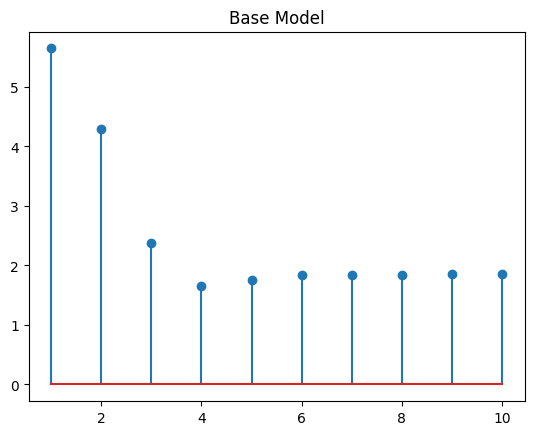

In [36]:
model = BaseModel(23).to(device)
evaluation_bins(model, testLoader, 'Base Model')

evaluation: 100%|██████████| 13/13 [00:00<00:00, 47.23it/s]


Accuracy of bins on testset: {0: 1.8574108818011257, 1: 1.8574108818011257, 2: 1.8574108818011257, 3: 1.8574108818011257, 4: 1.8574108818011257, 5: 1.8574108818011257, 6: 1.8574108818011257, 7: 1.8574108818011257, 8: 1.8574108818011257, 9: 1.8574108818011257}


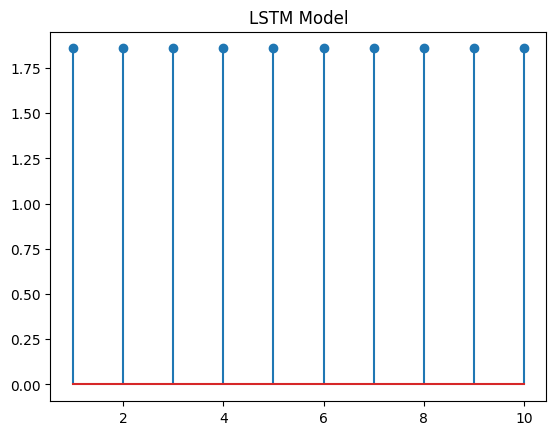

In [37]:
model = ChemLSTM(32,23).to(device)
evaluation_bins(model, testLoader, 'LSTM Model')

evaluation: 100%|██████████| 13/13 [00:00<00:00, 49.94it/s]


Accuracy of bins on testset: {0: 1.8574108818011257, 1: 1.8574108818011257, 2: 1.8574108818011257, 3: 1.8574108818011257, 4: 1.8574108818011257, 5: 1.8574108818011257, 6: 1.8574108818011257, 7: 1.8574108818011257, 8: 1.8574108818011257, 9: 1.8574108818011257}


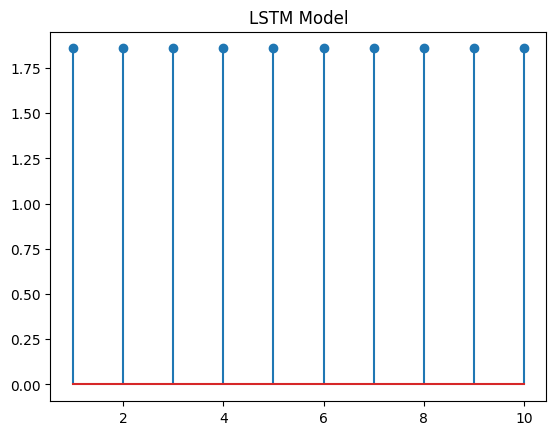

In [38]:
model = ChemLSTMBi(32,23).to(device)
evaluation_bins(model, testLoader, 'LSTM Model')

As we can see the accuracy of model decrease for each bins. also for MLP this accuracy has changed across different bins where the first bins has the most accuracy. but in LSTM and Bi-LSTM the accuracy is not changed across bins. it shows that evry bins has the same contribution on the final category in RNN models. but for MLP the first bins has the most contribution